In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [12]:
np.random.seed(410)

def date_parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [4]:
series = pd.read_csv("shampoo_sales.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=date_parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Shampoo_Sales, dtype: float64

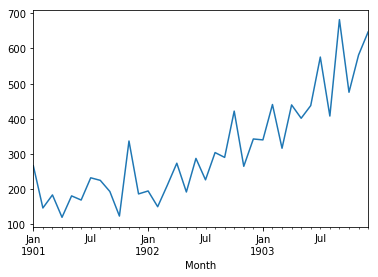

In [5]:
series.plot()
plt.show()

In [6]:
X = series.values
train,test = X[0:-12], X[-12:]  # use the last year as testing data
train

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3])

RMSE: 136.761


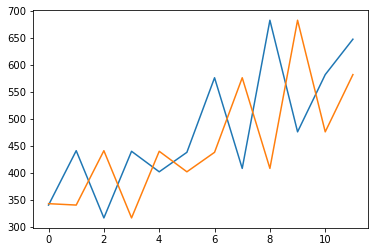

In [7]:
# Univariate time series
## Each time step will be walked one at a time - Walk Forward Validation
## For TEST DATA time t, t+1 will be predicted, then the ACTUAL t+1 value will be added to history data to predict t+2
## This is a baseline method, since you simply use the previous 1 step data as the prediction

history = [h for h in train]  # convert numpy array to normal array
prediction = []
for i in range(len(test)):
    prediction.append(history[-1])
    history.append(test[i])
    
# RMSE to show perdiction accuracy
rmse = np.sqrt(mean_squared_error(test, prediction))
print('RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(prediction)
plt.show()

In [8]:
# LSTM
# Step 1 - Data Preprocessing
## check stationary, make time series stationary
## transform the time series into supervised problem
## make observations in scale

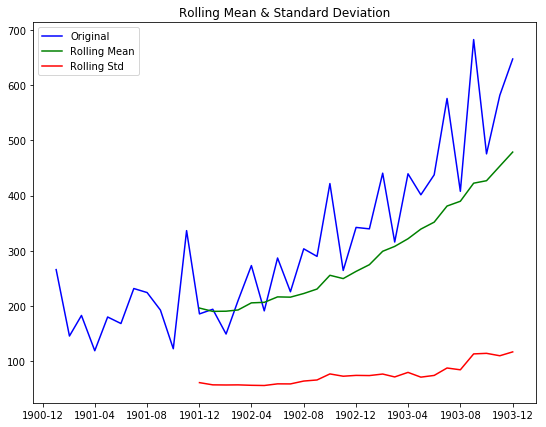

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [33]:
## check stationary
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(9,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
test_stationarity(series)

In [15]:
"""
From above result, we can see the data is far away from being stationary:
Test Statistic is larger than all the Critical Value
Neither rolling mean nor rolling std is flat
"""

In [34]:
## make time series stationary
## Differencing, you can use diff(), shift() built-in methods; or create your own
## Both diff(), shift() get same results, but the output will also contain time, instead of index
## methods created here is using index
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]  # ignore first NA value
        diff.append(value)
    return Series(diff)

diff_series = difference(series)
diff_series.head()

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64

In [41]:
## transform to supervised data - shift training data down as testing data

def ts2supervised(ts1, lag=1):
    ts1_df = pd.DataFrame(ts1)
    ts2_df = [ts1_df.shift(k) for k in range(1, lag+1)]  # shift DOWM lag steps
    ts2_df.append(ts1_df)
    df = concat(ts2_df, axis=1)  # first argument must be an iterable
    df.fillna(0, inplace=True)  # In this case, 0 tells LSTM it's the start point, since sales data has no 0 originally
    return df

supervised_data = ts2supervised(diff_series, 1)
supervised_data.columns = ['ts2', 'ts1']
supervised_data.head()

,ts2,ts1
0,0.0,-120.1
1,-120.1,37.2
2,37.2,-63.8
3,-63.8,61.0
4,61.0,-11.8


In [59]:
supervised_values = supervised_data.values
train, test = supervised_values[0:-12], supervised_values[-12:]   # first 2 years as train data, last year as test data

In [79]:
## As you can see, above values are between [-infinity, infinity], 
### tanh activation function (default LSTM activation function) outputs [-1, 1], 
### so better to scale the data input into [-1, 1]

def scale_data(my_data):
    my_scaler = MinMaxScaler(feature_range=(-1,1))
    my_scaler = scaler.fit(my_data)
    
    reshaped_data = my_data.reshape(my_data.shape[0], my_data.shape[1])
    scaled_data = my_scaler.transform(reshaped_data)
    
    return scaled_data, my_scaler

scaled_train, my_scaler_train = scale_data(train)
scaled_test, my_scaler_test = scale_data(test)

print(scaled_train.shape)
print(scaled_test.shape)

(23, 2)
(12, 2)


In [73]:
# Step2 - Model Fitting & Evaluation

## fit LSTM to training data
def fit_lstm(training_data, batch_size, nb_epoch, neurons):
    X, y = training_data[:, 0:-1], training_data[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)  # verbose=0 to disable debug info
        model.reset_states()
    return model

In [85]:
# You can repeat the experiments and check final RMSE distribution to see how reproduciable the results are
## It also can indicate how well the configuration would be expected to perform on unseen data on average
from tensorflow import set_random_seed
set_random_seed(410)

repeats = 10
rmse_lst = []
batch_size = 1  # batch size is the factor of train & test length, here it is 1
epochs = 410
neurons = 4  # this is a small scale problem, neurons<=5 should be fine
time_step = 1
feature_dimensions = 1

raw_values = series.values

for r in range(repeats):
    lstm_model = fit_lstm(scaled_train, batch_size, epochs, neurons)
    reshaped_train = scaled_train[:, 0].reshape(len(scaled_train), time_step, feature_dimensions)
    lstm_model.predict(reshaped_train, batch_size=batch_size)
    
    # walk forward validation on testing data
    predictions = []
    for i in range(len(scaled_test)):
        X, y = scaled_test[i, 0:-1], scaled_test[i, -1]
        X = X.reshape(time_step, feature_dimensions, len(X))
        y_forecast = lstm_model.predict(X, batch_size = batch_size)
        
        # invert scale
        new_row = [x for x in X] + [y_forecast]  # appending together
        np_array = np.array(new_row)
        np_array = np_array.reshape(feature_dimensions, len(np_array))
        inverted_scaled_y = my_scaler_test.inverse_transform(np_array)[0,-1]
        
        # invert differencing
        interval = len(scaled_test) + 1 - i
        inverted_diff_y = inverted_scaled_y = raw_values[-interval]
        
        predictions.append(inverted_diff_y)
        
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print "round " + str(r) + " - RMSE: " + str(rmse)
    rmse_lst.append(rmse)

round 0 - RMSE: 136.761318849
round 1 - RMSE: 136.761318849
round 2 - RMSE: 136.761318849
round 3 - RMSE: 136.761318849
round 4 - RMSE: 136.761318849
round 5 - RMSE: 136.761318849
round 6 - RMSE: 136.761318849
round 7 - RMSE: 136.761318849
round 8 - RMSE: 136.761318849
round 9 - RMSE: 136.761318849


<bound method DataFrame.describe of          rmse
0  136.761319
1  136.761319
2  136.761319
3  136.761319
4  136.761319
5  136.761319
6  136.761319
7  136.761319
8  136.761319
9  136.761319>


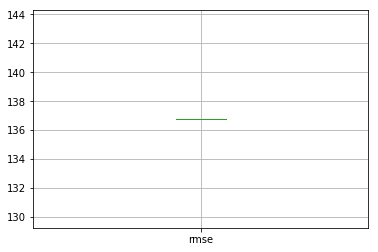

In [87]:
results = pd.DataFrame()
results['rmse'] = rmse_lst
print results.describe
results.boxplot()
plt.show()